In [6]:
!python -m pip install --upgrade pip


In [7]:
!pip install torch torchvision numpy matplotlib scikit-learn seaborn


In [8]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import confusion_matrix
import seaborn as sns


In [9]:
# Set directory and transformations
data_dir = 'EuroSAT_RGB'  # Adjust path as needed
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load dataset and split
dataset = ImageFolder(root=data_dir, transform=transform)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])


Here we determine our batch size. I experimented with smaller and larger batch sizes. For larger batch sizes, my accuracy decreased which I simply measure by comparing actual values and predicted values. For 3 my accuracy was slightly worse so I decided to just stick with a batch size of 4. 

In [10]:
batch_size = 4
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


Here we define our convolutional neural network. We employ a simple network with 2 layers that can be used to handle images. 

In [11]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Define layers
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.fc1 = nn.Linear(8*8*32, 1000)
        self.fc2 = nn.Linear(1000, len(dataset.classes))

    def forward(self, x):
        # Define forward pass
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

model = ConvNet()


When defining, the number of epcohs, I started with 10. I then increased the number to 10 but saw that the accuracy suffered. So, I slightly increased it to 12. For the learning rate, I found 0.0001 to be the best since higher and lower learning rates decreased our accuracy.

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
num_epochs = 12

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i + 1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')


Epoch [1/12], Step [100/5400], Loss: 1.6811
Epoch [1/12], Step [200/5400], Loss: 2.1626
Epoch [1/12], Step [300/5400], Loss: 1.5280
Epoch [1/12], Step [400/5400], Loss: 1.6767
Epoch [1/12], Step [500/5400], Loss: 1.9748
Epoch [1/12], Step [600/5400], Loss: 1.8070
Epoch [1/12], Step [700/5400], Loss: 0.9844
Epoch [1/12], Step [800/5400], Loss: 1.1886
Epoch [1/12], Step [900/5400], Loss: 1.2934
Epoch [1/12], Step [1000/5400], Loss: 0.9988
Epoch [1/12], Step [1100/5400], Loss: 0.5932
Epoch [1/12], Step [1200/5400], Loss: 1.1865
Epoch [1/12], Step [1300/5400], Loss: 1.7849
Epoch [1/12], Step [1400/5400], Loss: 1.4978
Epoch [1/12], Step [1500/5400], Loss: 1.1947
Epoch [1/12], Step [1600/5400], Loss: 2.3123
Epoch [1/12], Step [1700/5400], Loss: 0.6622
Epoch [1/12], Step [1800/5400], Loss: 0.7947
Epoch [1/12], Step [1900/5400], Loss: 1.1008
Epoch [1/12], Step [2000/5400], Loss: 0.8927
Epoch [1/12], Step [2100/5400], Loss: 1.8665
Epoch [1/12], Step [2200/5400], Loss: 1.6953
Epoch [1/12], Step 

Accuracy of the model on the test images: 82.4074074074074%


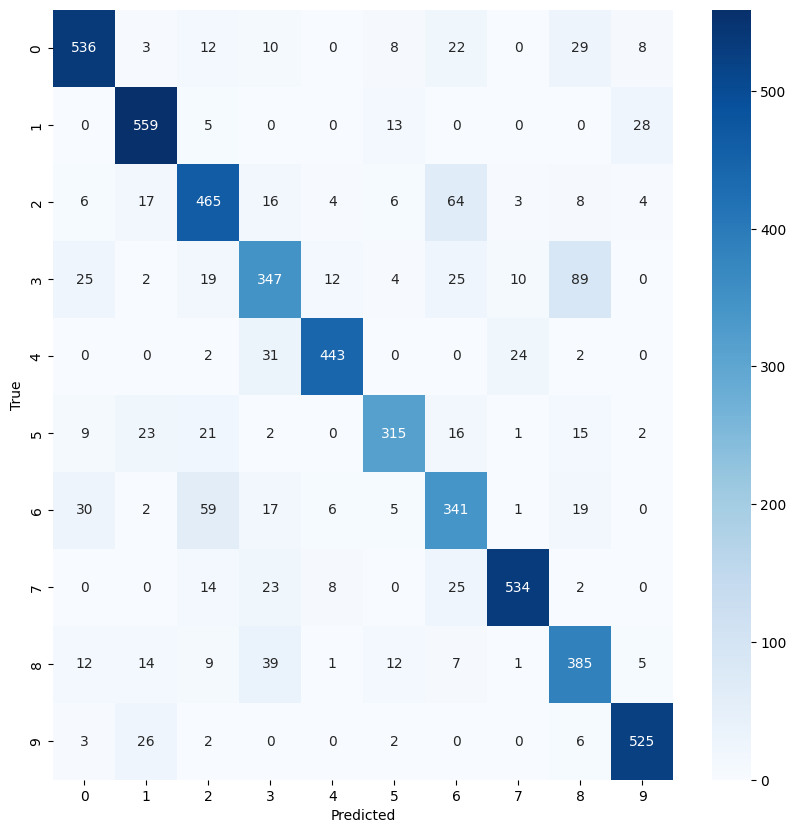

In [13]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_preds = []
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels)
        all_preds.extend(predicted)

# Print accuracy
accuracy = correct / total
print(f'Accuracy of the model on the test images: {100 * accuracy}%')

# Plot confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 10))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()


In [14]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


let's look at random images from our test set to se how our model performs.

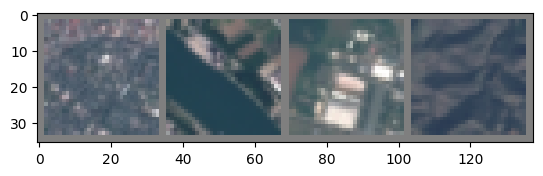

True labels: Residential River Industrial HerbaceousVegetation
Predicted labels: Residential Highway Industrial HerbaceousVegetation


In [15]:
dataiter = iter(test_loader)
images, labels = next(dataiter) 
imshow(torchvision.utils.make_grid(images))
print('True labels:', ' '.join(f'{dataset.classes[labels[j]]:5s}' for j in range(batch_size)))
print('Predicted labels:', ' '.join(f'{dataset.classes[all_preds[j]]:5s}' for j in range(batch_size)))
